# CNN Modelling

This project is for creating a CNN classifier for gesture recognition

In [1]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [2]:
dataset = pd.read_pickle('dataset.pkl')

In [3]:
def reshape_windows_tensor_with_labels(data, y):
    """
    Converts data from:
        recordings x windows x channels x samples
    to:
        total_windows x channels x samples
    """
    X_windows = []
    y_windows = []
    data = data.to_list()
    y = y.to_list()
    for rec_idx, rec in enumerate(data):
        rec = np.asarray(rec)
        if rec.shape[0] == 0:
            continue

        for window in rec:
            X_windows.append(window)
            y_windows.append(y[rec_idx])

    return np.asarray(X_windows), np.asarray(y_windows)

(1038,)


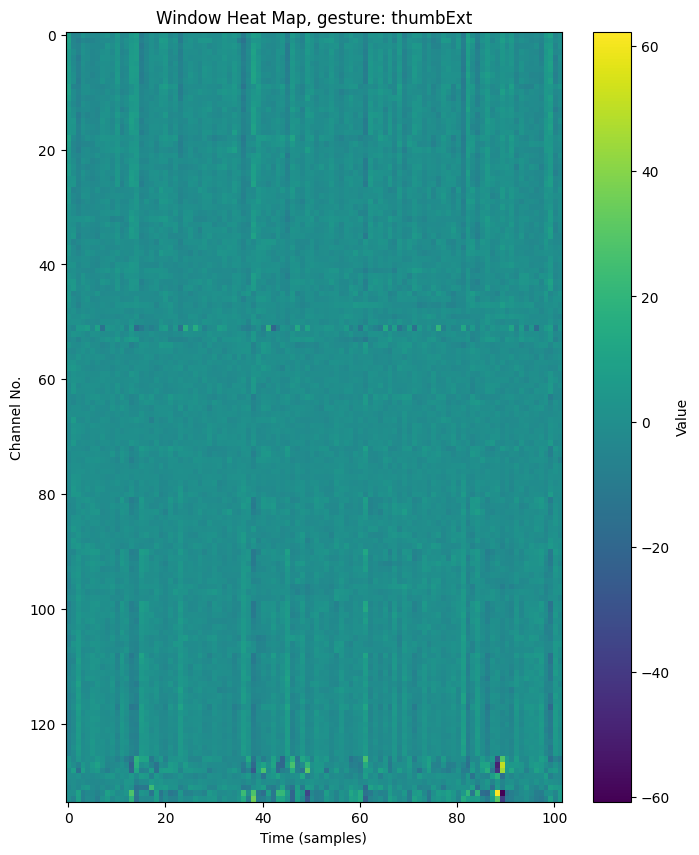

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)

print(X_train.shape)

X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
data = X_train[0]

plt.figure(figsize=(8, 10))
plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Window Heat Map, gesture: {y_train[0]}')
plt.xlabel('Time (samples)')
plt.ylabel('Channel No.')
plt.show()


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42499, 134, 102)
(42499,)
(10327, 134, 102)
(10327,)


In [6]:
print("Per-trial containers:")
print("X_train:", type(X_train), getattr(X_train, "shape", None))
print("y_train:", type(y_train), getattr(y_train, "shape", None))

# Convert from per-trial -> per-window (ready for CNN)
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print("\nPer-window tensors (CNN-ready):")
print("X_train shape:", X_train.shape)  # expected: (N_windows, C, T)
print("y_train shape:", y_train.shape)  # expected: (N_windows,)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Quick sanity check of channel/time dims
if X_train.ndim == 3:
    N, C, T = X_train.shape
    print(f"\nCNN expects [N, C, T] -> N={N}, C={C}, T={T}")
else:
    print("\nUnexpected X_train ndim:", X_train.ndim)

Per-trial containers:
X_train: <class 'numpy.ndarray'> (42499, 134, 102)
y_train: <class 'numpy.ndarray'> (42499,)

Per-window tensors (CNN-ready):
X_train shape: (42499, 134, 102)
y_train shape: (42499,)
X_test shape: (10327, 134, 102)
y_test shape: (10327,)

CNN expects [N, C, T] -> N=42499, C=134, T=102


In [ ]:
# Deep CNN in the SAME STYLE as your Assignment 4 (Sequential "conv blocks"),
# but adapted to EMG windows shaped (N, C, T) where C=134 and T=102.
#
# Uses YOUR exact split+reshape lines, then converts to Conv2d input: (N, 1, C, T)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import TensorDataset, DataLoader

# ----------------------------
# 1) Split + reshape
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    dataset["windows_raw"], dataset["movement"], test_size=0.2, random_state=42
)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print("CNN expects [N, C, T] ->", X_train.shape, y_train.shape)

# ----------------------------
# 2) Encode labels
# ----------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train).astype(np.int64, copy=False)
y_test_enc = le.transform(y_test).astype(np.int64, copy=False)
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# ----------------------------
# 3) Convert to torch tensors for Conv2d
#    (N, C, T) -> (N, 1, C, T)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N,1,C,T)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

print("Torch shapes:", X_train_tensor.shape, y_train_tensor.shape)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=(device.type == "cuda"))
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=(device.type == "cuda"))

# ----------------------------
# 4) Model
# ----------------------------
def make_deep_emg_cnn_model(num_classes: int):
    m = nn.Sequential(
        # Block 1
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 5), padding=(1, 2), bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 5), padding=(1, 2), bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.20),

        # Block 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.30),

        # Block 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.40),

        # Global pooling -> avoids hard-coding Linear(in_features=...)
        nn.AdaptiveAvgPool2d((1, 1)),

        # Head
        nn.Flatten(),
        nn.Linear(128, num_classes),
    )
    return m

model = make_deep_emg_cnn_model(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ----------------------------
# 5) Training loop
# ----------------------------
scaler = torch.GradScaler('cuda')

@torch.no_grad()
def evaluate(loader):
    model.eval()
    ys = []
    ps = []
    total_loss = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += float(loss.item()) * int(yb.size(0))
        n += int(yb.size(0))
        pred = torch.argmax(logits, dim=1)
        ys.append(yb.cpu().numpy())
        ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    acc = accuracy_score(y_true, y_pred)
    return total_loss / max(n, 1), acc, y_true, y_pred

EPOCHS = 30
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    n = 0

    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast('cuda'):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += float(loss.item()) * int(yb.size(0))
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        n += int(yb.size(0))

    train_loss = running_loss / max(n, 1)
    train_acc = correct / max(n, 1)

    val_loss, val_acc, _, _ = evaluate(test_loader)
    print(f"LOSS train {train_loss:.3e} valid {val_loss:.3e}, train acc {train_acc:.2f}, val acc {val_acc:.2f}")

# Final report
_, _, y_true, y_pred = evaluate(test_loader)
print("\nClassification report:")
print(classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), digits=4))

CNN expects [N, C, T] -> (42499, 134, 102) (42499,)
Classes: [np.str_('3digit'), np.str_('cilinder'), np.str_('fist'), np.str_('index_flex'), np.str_('middle_flex'), np.str_('pinch'), np.str_('point'), np.str_('thumbExt'), np.str_('thumbFlex')]
device: cuda
Torch shapes: torch.Size([42499, 1, 134, 102]) torch.Size([42499])
LOSS train 1.627e+00 valid 1.932e+00, train acc 0.40, val acc 0.37
LOSS train 1.112e+00 valid 1.459e+00, train acc 0.60, val acc 0.50
LOSS train 8.516e-01 valid 1.196e+00, train acc 0.71, val acc 0.62
LOSS train 7.065e-01 valid 9.983e-01, train acc 0.75, val acc 0.66
LOSS train 5.935e-01 valid 8.282e-01, train acc 0.80, val acc 0.71
LOSS train 4.893e-01 valid 9.516e-01, train acc 0.83, val acc 0.68
LOSS train 4.751e-01 valid 7.917e-01, train acc 0.84, val acc 0.73
LOSS train 4.565e-01 valid 9.549e-01, train acc 0.84, val acc 0.71
LOSS train 4.339e-01 valid 7.547e-01, train acc 0.85, val acc 0.76
LOSS train 4.090e-01 valid 7.121e-01, train acc 0.86, val acc 0.76
LOSS 